## 线性回归模型

### 数据准备

跟上面一样要实现一个简单的线性回归模型


这里要实现的线性回归为：
Y= Xw + b
这里要实现的参数值为：
w = [2.0,-1.0]
b = 3.0

其中噪声项ϵ服从均值为0、标准差为2的正态分布。噪声代表了数据集中无意义的干扰。


In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()

    # 计算当天时间的秒数，记录的时间的开文天文台的时间
    today_ts = ts%(24*60*60)

    # 计算当前的日期时：需要+8表示当前北京时间
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    # 计算分钟
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    # 计算秒钟
    second = tf.cast(tf.floor(today_ts%60),tf.int32)

    # 是否需要在前面加0
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))

    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*5,end = "")
    tf.print(timestring)

In [7]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf


print(tf.__version__)

#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


2.1.0


Text(0, 0.5, 'y')

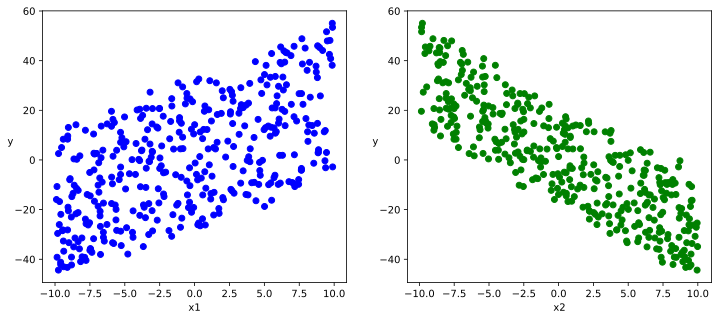

In [2]:
# 数据可视化

# 这个是什么意思
%matplotlib inline
%config InlineBackend.figure_format='svg'

plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0],c="b")
plt.xlabel("x1")
plt.ylabel("y",rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0],c="g")
plt.xlabel("x2")
plt.ylabel("y",rotation=0)


In [8]:
# 建立数据管道迭代器
# 这样可以实现mini_batch 

# 这里使用python中的数据生成yield工具
def data_iter(features,labels,batch_size=8):
    # 获取样本数据的大小
    num_examples = len(features)
    # 将样本数据进行标号
    indices = list(range(num_examples))
    # 对样本数据进行随机洗牌
    np.random.shuffle(indices)

    # 开始每次取出batch_size个数据
    for i in range(0,num_examples,batch_size):
        # 获得随机个数据
        indexs = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(X,indexs),tf.gather(Y,indexs)

In [12]:
batch_size = 8
# 利用next来获取相关的数据
(features,labels) = next(data_iter(X,Y,batch_size))
tf.print(features)
tf.print(labels)

[[-3.73191357 -1.17770195]
 [7.20563126 -9.28190231]
 [-6.84293509 -3.40452909]
 ...
 [1.00431252 -3.28527451]
 [-7.30628 -0.545401573]
 [4.14184093 -0.815513611]]
[[-3.11739135]
 [48.5800514]
 [-0.17353636]
 ...
 [13.5867577]
 [-11.8729601]
 [11.5520773]]


### 定义模型

定义模型需要做的事情：
- 定义参数变量
    - 这里的参数是需要在模型训练中来更新的参数，比如w,b
    - 变量这里指的是，使用tf.Variable来定义，这是tensorflow自己的变量体系，所以里面的数据是可以不断变化的，与tf.constant对应
    - 还需要考虑参数的初始化方式：赋值为零，Xavier 初始值,He 初始值
- 定义模型
    - 这里的模型可以简单的理解为：函数模型
    - 广泛的说：正向传播的模型架构
        - 比如神经网络模型，模型的层数：输入层，隐藏层，输出层
        - 比如CNN网络模型：输入层，卷积层，池化层，输出层等等
- 定义损失函数

**关于tf.reduce**

理解为压缩求和/平均/...，用于降维

>Args:
- input_tensor: The tensor to reduce. Should have numeric type. #输入
- axis: The dimensions to reduce. If None (the default), reduces all dimensions. Must be in the range （rank(input_tensor), rank(input_tensor)).#取0第一维，取1第二维，取-1最后一维 是要求和的 0表示列或1表示行，没有写出来，则默认所有维度都要求和；
- keepdims: If true, retains reduced dimensions with length 1.#按照原来的维度
- name: A name for the operation (optional).
- reduction_indices: The old (deprecated) name for axis.#axis的原来的名字



In [9]:
# 参数变量
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype=tf.float32))

class LinearRegression:
    # 定义模型的正向传播
    def __call__(self,x):
        return x@w+b

    def loss_func(self,y_true,y_pred):
        # 计算真实标签与预测值的差值平方
        return tf.reduce_mean((y_true-y_pred)**2/2)

# 构建模型
model = LinearRegression()


### 训练模型



In [10]:
def train_step(model,features,labels):
    with tf.GradientTape() as tape:
        # 正向传播计算预测值
        predictions = model(features)
        # 计算损失值
        loss = model.loss_func(labels,predictions)
    # 反向传播计算梯度值
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 更新参数
    w.assign(w-0.001*dloss_dw)
    b.assign(b-0.001*dloss_db)

    return loss

In [12]:
# 测试上面函数的效果

batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=164.53703>

In [11]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features,labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%100 ==0 :
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

            

In [12]:
# 训练模型500步
train_model(model,epochs=500)

==================================================08:43:50
epoch = 100 loss =  1.67761493
w = [[1.99202681]
 [-3.0292511]]
b = [[2.87097764]]
==================================================08:44:02
epoch = 200 loss =  1.3873533
w = [[1.9920752]
 [-3.02830625]]
b = [[2.92267632]]
==================================================08:44:16
epoch = 300 loss =  1.35428238
w = [[1.98740327]
 [-3.02621245]]
b = [[2.92323565]]
==================================================08:44:27
epoch = 400 loss =  1.64197469
w = [[1.99329233]
 [-3.01839232]]
b = [[2.92391181]]
==================================================08:44:41
epoch = 500 loss =  1.12677383
w = [[1.98528171]
 [-3.02290964]]
b = [[2.92341757]]
